In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from scipy.special import expit

from models.multiGaussian import MultiGaussianAdaptedSkiRental
from models.varianceAware import VarianceAwareSkiRental
from models.expectedCost import ExpectedCostSkiRental
from models.bayesian import BayesianSkiRental
from models.hybrid import HybridVarianceAwareSkiRental, HybridVarianceAwareSkiRentalWithScaling
from models.gaussianNoise import GaussianNoiseSkiRental
from models.bayesianDiscrete import DiscreteBayesianSkiRental


In [2]:
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)
logging.getLogger("pytensor").setLevel(logging.ERROR)


 # Experiment 1 

/var/folders/97/37rhzgks7qzdhsqdg2l1qbyc0000gn/T/ipykernel_29774/4139846440.py:144: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout(pad=1.2)


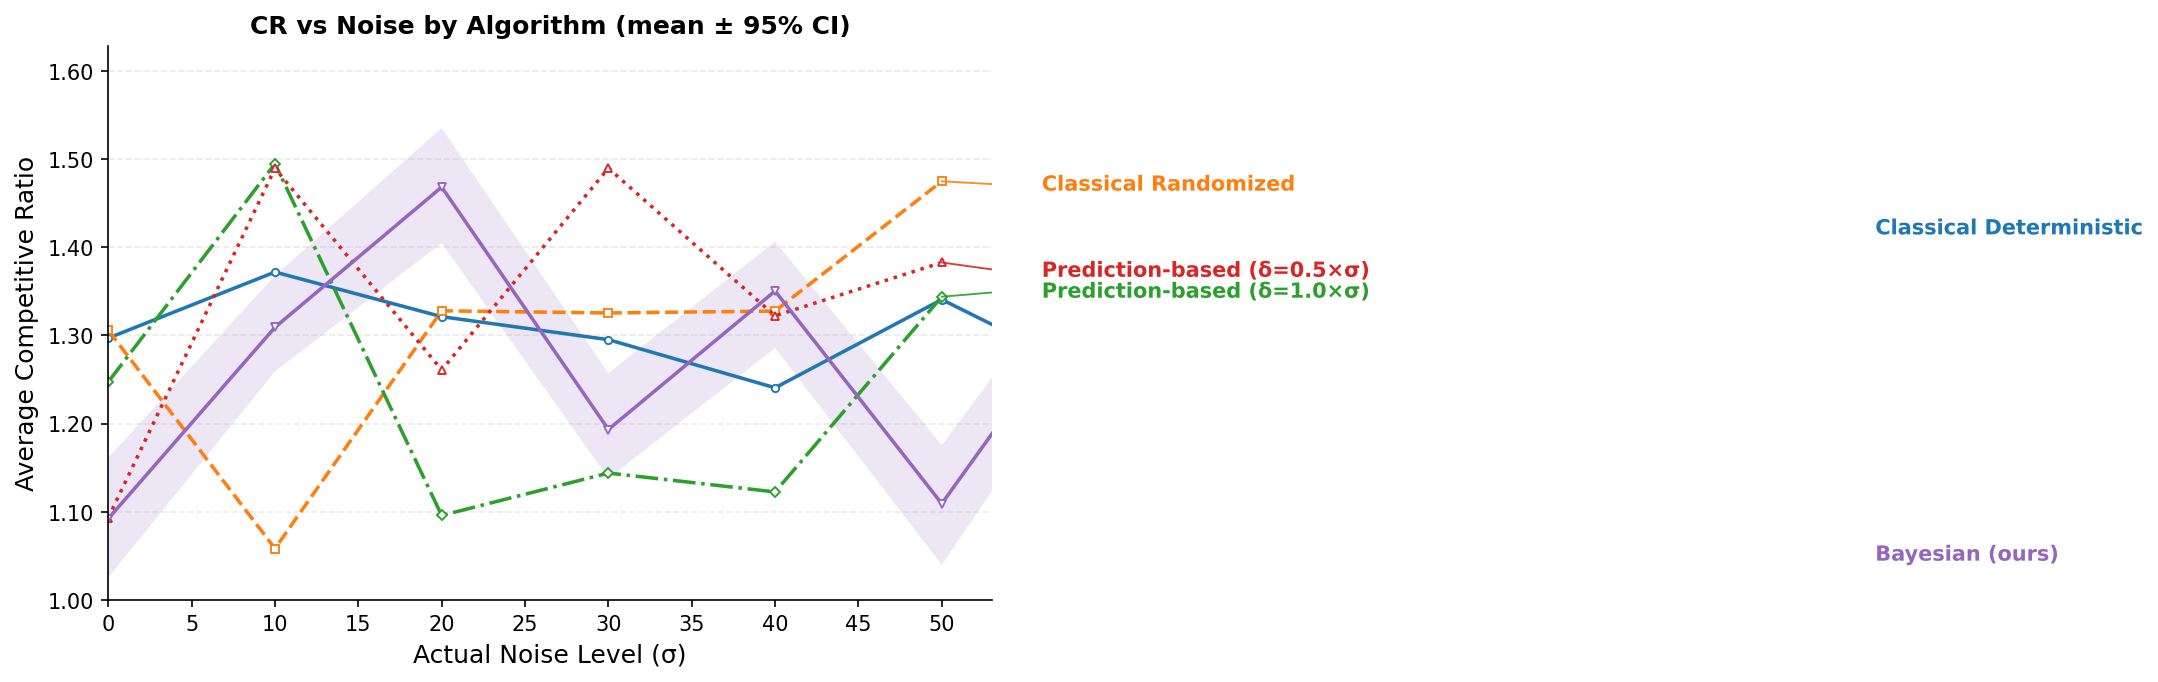

Saved: figs-final/exp1.png


In [15]:
# -------------------------------------------------
# (6) 플로팅: 선 끝 라벨링(legend 제거, PNG만 저장) — 수평 연장 제거 버전
# -------------------------------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.ticker import MaxNLocator, FuncFormatter

# ===== 데이터 준비: agg 없으면 샘플 생성 =====
if 'agg' not in globals():
    np.random.seed(0)
    algos = [
        "Classical Deterministic",
        "Classical Randomized",
        "Prediction-based (δ=1.0×σ)",
        "Prediction-based (δ=0.5×σ)",
        "Bayesian (ours)"
    ]
    # 일부 알고리즘은 50까지만, 일부는 100까지 만들어 상황 재현
    rows = []
    for algo in algos:
        if algo in ["Classical Deterministic", "Bayesian (ours)"]:
            noise_levels = np.arange(0, 101, 10)   # 0..100
        else:
            noise_levels = np.arange(0, 51, 10)    # 0..50 (이후 없음)

        mean   = 1.05 + 0.45 * np.random.rand(len(noise_levels))
        ci_low = mean - 0.05 - 0.02 * np.random.rand(len(noise_levels))
        ci_high= mean + 0.05 + 0.02 * np.random.rand(len(noise_levels))
        for n, m, lo, hi in zip(noise_levels, mean, ci_low, ci_high):
            rows.append((algo, n, m, lo, hi))
    agg = pd.DataFrame(rows, columns=["algorithm", "noise", "mean", "ci_low", "ci_high"])

# ===== 스타일/순서 =====
order      = agg["algorithm"].unique().tolist()
palette    = list(plt.get_cmap("tab10").colors)
linestyles = ["-", "--", "-.", ":"]
markers    = ["o", "s", "D", "^", "v", "X", "P"]

# ===== 플롯 시작 =====
fig, ax = plt.subplots(figsize=(7.6, 4.8))
end_points = []  # (algo, x_last, y_last, color)

for i, algo in enumerate(order):
    tmp = agg[agg["algorithm"] == algo].copy()
    if tmp.empty:
        continue

    # 안전: numeric + 정렬
    for col in ["noise", "mean", "ci_low", "ci_high"]:
        tmp[col] = pd.to_numeric(tmp[col], errors="coerce")
    tmp = tmp.dropna(subset=["noise", "mean"]).sort_values("noise")

    # >>> 핵심: 패딩/재색인/보간으로 '뒤를 채우지 않음' (수평선 방지)
    x = tmp["noise"].to_numpy()
    y = tmp["mean"].to_numpy()
    lo = tmp["ci_low"].to_numpy()
    hi = tmp["ci_high"].to_numpy()

    color = palette[i % len(palette)]
    ls    = linestyles[i % len(linestyles)]
    mk    = markers[i % len(markers)]

    # 우리 모델만 신뢰구간 음영 (있는 구간까지만)
    if algo == "Bayesian (ours)":
        ax.fill_between(x, lo, hi, alpha=0.16, facecolor=color, edgecolor="none")

    # 모든 모델 라인 + 마커 (있는 구간까지만)
    ax.plot(x, y, linewidth=1.7, linestyle=ls, marker=mk, markersize=3.5,
            markerfacecolor="white", markeredgewidth=0.9, color=color)

    # 라벨용 끝점 = 실제 마지막 데이터 지점
    x_last = float(x[-1])
    y_last = float(y[-1])
    end_points.append((algo, x_last, y_last, color))

# ===== 축/눈금/타이틀 =====
ax.set_xlabel("Actual Noise Level (σ)")
ax.set_ylabel("Average Competitive Ratio")
ax.set_title("CR vs Noise by Algorithm (mean ± 95% CI)")
ax.set_xlim(0, 53)
ax.set_xticks(np.arange(0, 53, 10))
y_min = 1.0
y_max = min(2.5, float(agg["ci_high"].max()) * 1.05)
ax.set_ylim(y_min, y_max)
ax.xaxis.set_major_locator(MaxNLocator(nbins=11, integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.25, linestyle="--")
ax.grid(axis='x', visible=False)

# ===== 선 끝 라벨링 (충돌 방지) =====
end_points.sort(key=lambda t: t[2])  # y 기준 정렬
yrange  = y_max - y_min
xpad    = 6.0
min_sep = 0.035 * yrange
base_dy = 0.012 * yrange
N = len(end_points)

lin_offsets = np.linspace(-base_dy, base_dy, num=max(N, 1))
desired_y = {ep[0]: np.clip(ep[2] + off, y_min + 0.01*yrange, y_max - 0.01*yrange)
             for off, ep in zip(lin_offsets, end_points)}

group_nudge = {
    "Classical Deterministic":      +0.018 * yrange,
    "Classical Randomized":         -0.018 * yrange,
    "Prediction-based (δ=1.0×σ)":   +0.015 * yrange,
    "Prediction-based (δ=0.5×σ)":   -0.015 * yrange,
    "Bayesian (ours)":               0.0,
}
for algo, _, _, _ in end_points:
    desired_y[algo] = float(np.clip(
        desired_y[algo] + group_nudge.get(algo, 0.0),
        y_min + 0.01*yrange, y_max - 0.01*yrange
    ))

# 아래→위, 위→아래 스윕
placed = []
for algo, x_last, y_last, color in end_points:
    y_tgt = desired_y[algo]
    if placed:
        y_tgt = max(y_tgt, placed[-1][1] + min_sep)
    y_tgt = min(y_tgt, y_max - 0.01*yrange)
    placed.append((algo, y_tgt))
for i in range(len(placed)-2, -1, -1):
    algo, y_tgt = placed[i]
    _, y_above = placed[i+1]
    if y_above - y_tgt < min_sep:
        placed[i] = (algo, max(y_min + 0.01*yrange, y_above - min_sep))

# 연결선 + 텍스트
pos_map = dict(placed)
for algo, x_last, y_last, color in end_points:
    y_lab = pos_map.get(algo, y_last)
    ax.plot([x_last, x_last + 0.6*xpad], [y_last, y_lab],
            color=color, linewidth=0.9, alpha=0.9)
    ax.text(x_last + xpad, y_lab, algo, color=color, fontsize=10,
            va='center', ha='left', fontweight='semibold',
            path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.9)])

fig.tight_layout(pad=1.2)

# ===== 저장(PNG만) =====
os.makedirs("figs-final", exist_ok=True)
out_png = "figs-final/exp1.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")


# Experiment 2

 Saved: figs-bosun/exp2.png (plot type = boxplot)


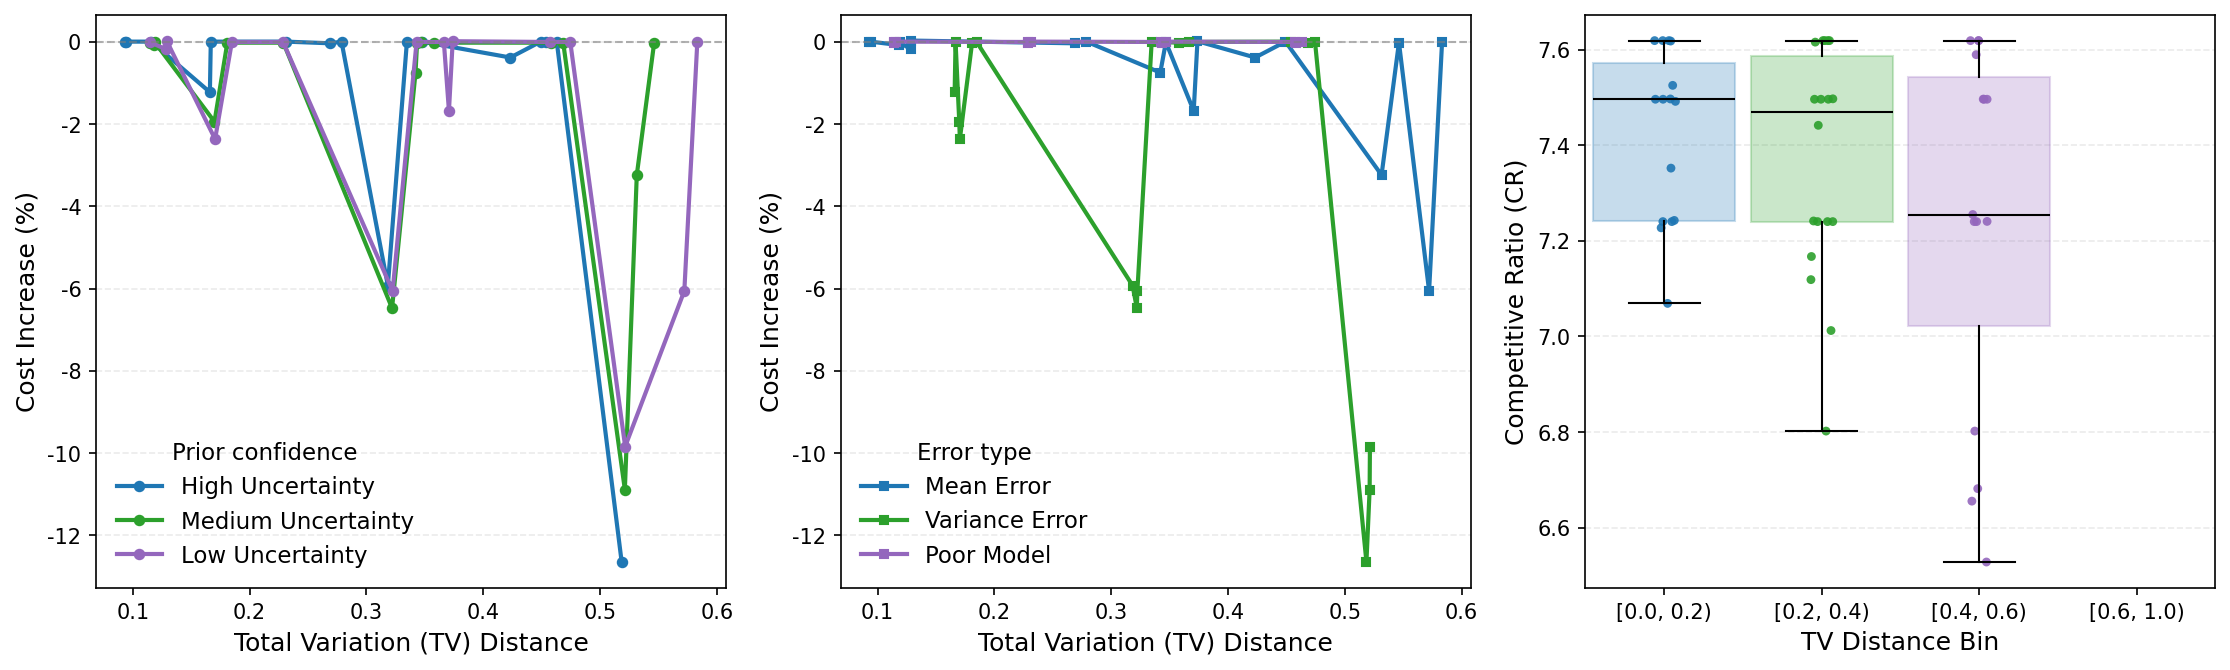

In [20]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans", "Helvetica", "Arial"],
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.7,
    "figure.dpi": 150,
    "savefig.dpi": 300,
})

# ==== 데이터 로드 ====
if 'df' not in globals():
    df = pd.read_csv("figs-bosun/exp3.csv")

for c in [
    "tv_distance", "pct_cost_increase", "mean_cr", "std_cr", "p95_cr", "p99_cr",
    "failure_rate", "severe_fail", "t_star", "t_star_optimal", "threshold_error",
    "avg_cost", "baseline_cost", "regret"
]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ==== 색상 매핑 (Experiment 4와 통일) ====
color_map_cfg = {
    "High": "tab:blue",
    "Medium": "tab:green",
    "Low": "tab:purple",
}

color_map_type = {
    "Mean Error": "tab:blue",
    "Variance Error": "tab:green",
    "Poor Model": "tab:purple",
}

# TV bin 색 (오른쪽 패널용) – 순서대로 bin1, bin2, bin3, bin4...
bin_colors = ["tab:blue", "tab:green", "tab:purple", "tab:gray"]


def plot_focused_three_safe(
    d,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
    outfile="figs-bosun/exp2.png"
):
    d = d.copy()

    # ----- (A) Performance Degradation by prior confidence -----
    configs = list(d["config"].dropna().unique())
    order_key = {"High": 0, "Medium": 1, "Low": 2}
    configs_sorted = sorted(configs, key=lambda s: order_key.get(s.split()[0], 99))

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15, 4.6))

    for cfg in configs_sorted:
        sub = d[d["config"] == cfg].sort_values("tv_distance")

        full_label = cfg.split("(")[0].strip()   # "High Uncertainty"
        base_label = full_label.split()[0]       # "High"
        color = color_map_cfg.get(base_label, "black")

        axA.plot(
            sub["tv_distance"], sub["pct_cost_increase"],
            marker="o", linewidth=2.0, markersize=4.5,
            color=color,
            label=full_label
        )

    axA.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axA.set_xlabel("Total Variation (TV) Distance")
    axA.set_ylabel("Cost Increase (%)")
    axA.grid(axis="y", alpha=0.25, linestyle="--")
    axA.legend(frameon=False, title="Prior confidence")

    # ----- (B) Impact by scenario type -----
    type_order = ["Mean Error", "Variance Error", "Poor Model"]
    for tp in type_order:
        sub = d[d["scenario_type"] == tp].sort_values("tv_distance")
        if len(sub) == 0:
            continue

        color = color_map_type.get(tp, "black")

        axB.plot(
            sub["tv_distance"], sub["pct_cost_increase"],
            marker="s", linewidth=2.0, markersize=4.0,
            color=color,
            label=tp
        )

    axB.axhline(0, color="gray", linestyle="--", linewidth=1.0, alpha=0.6)
    axB.set_xlabel("Total Variation (TV) Distance")
    axB.set_ylabel("Cost Increase (%)")
    axB.grid(axis="y", alpha=0.25, linestyle="--")
    axB.legend(frameon=False, title="Error type")

    # ----- (C) CR Distribution by TV bin -----
    tv_edges = np.asarray(tv_edges, dtype=float)
    tv_labels = [f"[{tv_edges[i]:.1f}, {tv_edges[i+1]:.1f})"
                 for i in range(len(tv_edges) - 1)]
    d["tv_bin"] = pd.cut(
        d["tv_distance"], bins=tv_edges,
        labels=tv_labels, include_lowest=True
    )

    bin_series = []
    for lbl in tv_labels:
        vals = d.loc[d["tv_bin"] == lbl, "mean_cr"]
        vals = vals[np.isfinite(vals)]
        bin_series.append(vals.values)

    positions = np.arange(1, len(tv_labels) + 1)

    # violin / boxplot 안전 처리
    safe_data = []
    has_violin = True
    for vals in bin_series:
        arr = np.asarray(vals, dtype=float)
        if arr.size < 2:
            has_violin = False
        safe_data.append(arr if arr.size > 0 else np.array([np.nan, np.nan]))

    if has_violin:
        parts = axC.violinplot(
            safe_data, positions=positions, widths=0.9,
            showmeans=False, showmedians=True, showextrema=False
        )
        for i, pc in enumerate(parts['bodies']):
            c = bin_colors[i % len(bin_colors)]
            pc.set_facecolor(c)
            pc.set_edgecolor("none")
            pc.set_alpha(0.25)
    else:
        bp = axC.boxplot(
            safe_data, positions=positions, widths=0.9,
            showfliers=False, patch_artist=True
        )
        for i, patch in enumerate(bp['boxes']):
            c = bin_colors[i % len(bin_colors)]
            patch.set_facecolor(c)
            patch.set_edgecolor(c)
            patch.set_alpha(0.25)
        # median/whisker 색도 살짝 정리 (선택)
        for line in bp['medians']:
            line.set_color("black")
        for line in bp['whiskers']:
            line.set_color("black")
        for line in bp['caps']:
            line.set_color("black")

    # scatter 색도 bin별로 맞추기
    rng = np.random.default_rng(42)
    for idx, (pos, vals) in enumerate(zip(positions, bin_series)):
        if vals.size == 0:
            continue
        c = bin_colors[idx % len(bin_colors)]
        x = pos + (rng.random(vals.size) - 0.5) * 0.15
        axC.scatter(x, vals, s=18, alpha=0.9, color=c, edgecolors="none")

    axC.set_xlabel("TV Distance Bin")
    axC.set_ylabel("Competitive Ratio (CR)")
    axC.set_xticks(positions)
    axC.set_xticklabels(tv_labels)
    axC.grid(axis="y", alpha=0.25, linestyle="--")
    axC.yaxis.set_major_formatter(
        FuncFormatter(lambda v, pos: f"{v:.1f}" if v < 10 else f"{int(v)}")
    )

    fig.tight_layout()
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    fig.savefig(outfile, bbox_inches="tight")
    print(f" Saved: {outfile} (plot type = {'violin' if has_violin else 'boxplot'})")

    return fig

# === 실행 ===
fig = plot_focused_three_safe(
    df,
    tv_edges=(0.0, 0.2, 0.4, 0.6, 1.01),
    outfile="figs-bosun/exp2.png"
)


# Experiment 3

# Experiment 4

[t*] Bi-modal: 81, Tri-modal: 81, Seasonal: 81  (with b=25, M=80)


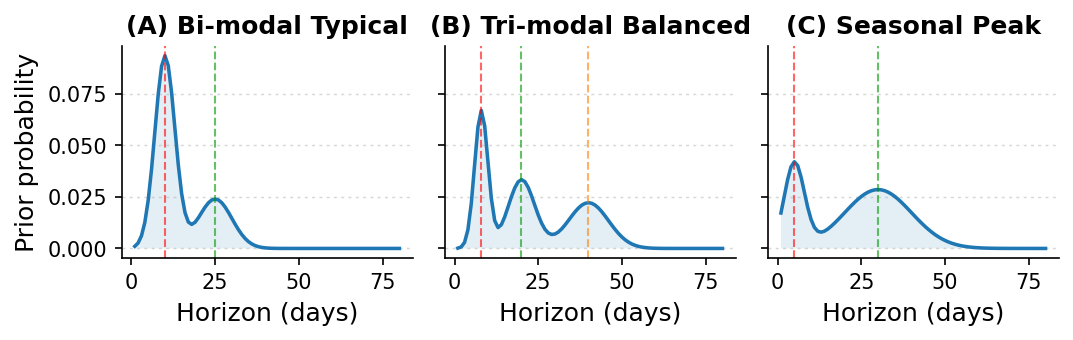

Saved: figs-final/exp4-2.png


In [8]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm

# ---------------------------
# 기본 스타일(논문형)
# ---------------------------
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": [
        "DejaVu Sans",        # 기본
        "Helvetica",          # macOS
        "Arial",              # Windows fallback
    ],
    "font.weight": "regular",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titleweight": "semibold",
    "axes.labelweight": "regular",
    "lines.linewidth": 1.7,
    "savefig.dpi": 600,
    "figure.dpi": 150,
})



os.makedirs("figs-bosun", exist_ok=True)

# ---------------------------
# 유틸: prior 생성 & 정규화
# ---------------------------
def discretize_gaussian_mixture(M, components):
    """
    components: list of (weight, mu, sigma)
    returns prior over k=1..M (np.array length M)
    """
    x = np.arange(1, M+1)
    p = np.zeros_like(x, dtype=float)
    for w, mu, sigma in components:
        p += w * norm.pdf(x, loc=mu, scale=sigma)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

def discretize_trimodal(M, modes, stds, weights):
    x = np.arange(1, M+1)
    p = np.zeros(M, dtype=float)
    for w, m, s in zip(weights, modes, stds):
        p += w * norm.pdf(x, loc=m, scale=s)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

# ---------------------------
# t* 계산 (Bayesian 잔여렌탈 기대비용 규칙)
# ---------------------------
def optimal_t_star(b, M, prior):
    """
    prior[k-1] = P(K=k)
    buy at first t with b <= E[min{K-t+1,b} | K>=t]
    if never, return M+1 (never buy)
    """
    prior = np.asarray(prior, dtype=float)
    prior /= prior.sum()
    # 누적 생존확률 Z_t = P[K>=t]
    Z = np.flip(np.cumsum(np.flip(prior)))  # Z[t-1] = sum_{k=t..M} prior[k-1]
    for t in range(1, M+1):
        if Z[t-1] <= 0:
            continue
        # posterior on {K>=t}: p_{t,k} = prior[k-1]/Z_t for k>=t
        # E_rent(t) = sum_{k=t..M} p_{t,k} * min{k - t + 1, b}
        ks = np.arange(t, M+1)
        post = prior[ks-1] / Z[t-1]
        rent_costs = np.minimum(ks - t + 1, b)
        E_rent = np.sum(post * rent_costs)
        if b <= E_rent:
            return t
    return M + 1  # never buy

# ---------------------------
# 케이스 정의 (논문 서술과 동일)
# ---------------------------
M = 80   # 그림 가독성을 위해 축소. 논문표현 맞추려면 60~120 권장
# !!! 텍스트의 t*를 재현하려면 b를 조정하세요 !!!
b = 25   # 예: 25 정도로 두면 10/25/30 같은 모드에서 직관적인 t*가 나옴

# (1) Bi-modal Typical: 0.7*N(10,3^2) + 0.3*N(25,5^2)
prior_bi = discretize_gaussian_mixture(
    M, components=[(0.7, 10, 3), (0.3, 25, 5)]
)

# (2) Tri-modal Balanced: equal weights at 8, 20, 40
prior_tri = discretize_trimodal(
    M, modes=[8, 20, 40], stds=[2, 4, 6], weights=[1/3, 1/3, 1/3]
)

# (3) Seasonal Peak: 0.3*N(5,3^2) + 0.7*N(30,10^2)
prior_season = discretize_gaussian_mixture(
    M, components=[(0.3, 5, 3), (0.7, 30, 10)]
)

# t* 계산
t_bi  = optimal_t_star(b, M, prior_bi)
t_tri = optimal_t_star(b, M, prior_tri)
t_sea = optimal_t_star(b, M, prior_season)

print(f"[t*] Bi-modal: {t_bi}, Tri-modal: {t_tri}, Seasonal: {t_sea}  (with b={b}, M={M})")

# ---------------------------
# 그림: 3-패널 (논문 형식)
# ---------------------------
fig, axes = plt.subplots(1, 3, figsize=(7.2, 2.4), sharey=True)

cases = [
    ("(A) Bi-modal Typical", prior_bi, [10, 25], [(1.0, 0, 0), (0, 0.6, 0)], t_bi),
    ("(B) Tri-modal Balanced", prior_tri, [8, 20, 40], [(1.0, 0, 0), (0, 0.6, 0), (1.0, 0.5, 0)], t_tri),
    ("(C) Seasonal Peak", prior_season, [5, 30], [(1.0, 0, 0), (0, 0.6, 0)], t_sea),
]

x = np.arange(1, M+1)
shadow = [pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]

for ax, (title, prior, modes, mode_colors, t_star) in zip(axes, cases):
    # prior 곡선 + 리본
    ax.plot(x, prior, color="tab:blue", linewidth=1.7)
    ax.fill_between(x, 0, prior, color="tab:blue", alpha=0.12, edgecolor="none")

    # 모드 표시(점선)
    for m, c in zip(modes, mode_colors):
        ax.axvline(m, color=c, linestyle="--", linewidth=1.0, alpha=0.6)

    # t* 표시(굵은 점선 + 라벨 shadow)
    if t_star <= M:
        ax.axvline(t_star, color="tab:orange", linestyle="--", linewidth=2.0, alpha=0.9)
        ax.text(t_star+0.5, max(prior)*0.9, r"$t^\*$",
                color="tab:orange", fontsize=11, va="top", ha="left",
                path_effects=shadow)

    # 축/레이블
    ax.set_title(title)
    ax.set_xlabel("Horizon (days)")
    ax.grid(True, axis="y", linestyle=(0, (2, 3)), linewidth=0.7, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Prior probability")
fig.tight_layout()
out_png = "figs-final/exp4-2.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")


[t*] Bi-modal: 81, Tri-modal: 81, Seasonal: 81  (with b=25, M=80)


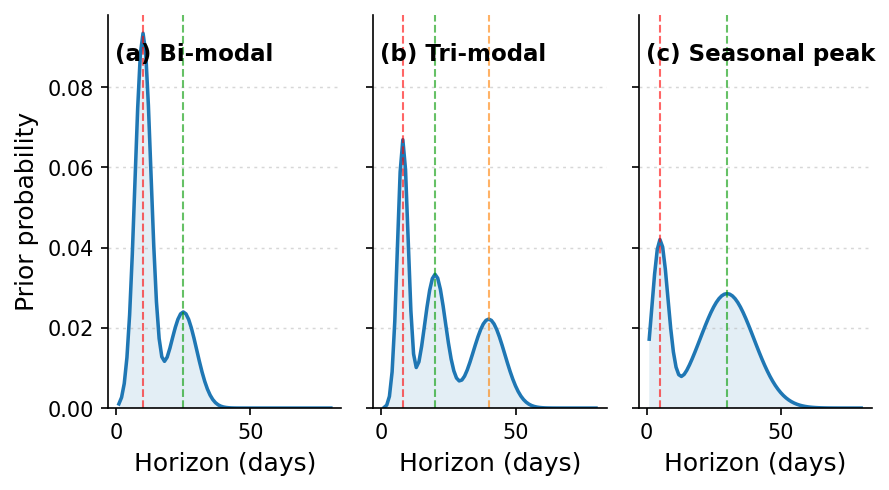

Saved: figs-bosun/experiment4.png


In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm

# ---------------------------
# 기본 스타일(논문형)
# ---------------------------
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": [
        "DejaVu Sans",        # 기본
        "Helvetica",          # macOS
        "Arial",              # Windows fallback
    ],
    "font.weight": "regular",
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titleweight": "semibold",
    "axes.labelweight": "regular",
    "lines.linewidth": 1.7,
    "savefig.dpi": 600,
    "figure.dpi": 150,
})

os.makedirs("figs-bosun", exist_ok=True)

# ---------------------------
# 유틸: prior 생성 & 정규화
# ---------------------------
def discretize_gaussian_mixture(M, components):
    """
    components: list of (weight, mu, sigma)
    returns prior over k=1..M (np.array length M)
    """
    x = np.arange(1, M+1)
    p = np.zeros_like(x, dtype=float)
    for w, mu, sigma in components:
        p += w * norm.pdf(x, loc=mu, scale=sigma)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

def discretize_trimodal(M, modes, stds, weights):
    x = np.arange(1, M+1)
    p = np.zeros(M, dtype=float)
    for w, m, s in zip(weights, modes, stds):
        p += w * norm.pdf(x, loc=m, scale=s)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

# ---------------------------
# t* 계산 (Bayesian 잔여렌탈 기대비용 규칙)
# ---------------------------
def optimal_t_star(b, M, prior):
    """
    prior[k-1] = P(K=k)
    buy at first t with b <= E[min{K-t+1,b} | K>=t]
    if never, return M+1 (never buy)
    """
    prior = np.asarray(prior, dtype=float)
    prior /= prior.sum()
    # 누적 생존확률 Z_t = P[K>=t]
    Z = np.flip(np.cumsum(np.flip(prior)))  # Z[t-1] = sum_{k=t..M} prior[k-1]
    for t in range(1, M+1):
        if Z[t-1] <= 0:
            continue
        # posterior on {K>=t}: p_{t,k} = prior[k-1]/Z_t for k>=t
        ks = np.arange(t, M+1)
        post = prior[ks-1] / Z[t-1]
        rent_costs = np.minimum(ks - t + 1, b)
        E_rent = np.sum(post * rent_costs)
        if b <= E_rent:
            return t
    return M + 1  # never buy

# ---------------------------
# 케이스 정의 (논문 서술과 동일)
# ---------------------------
M = 80   # 그림 가독성을 위해 축소
b = 25   # 구매 비용

# (1) Bi-modal Typical: 0.7*N(10,3^2) + 0.3*N(25,5^2)
prior_bi = discretize_gaussian_mixture(
    M, components=[(0.7, 10, 3), (0.3, 25, 5)]
)

# (2) Tri-modal Balanced: equal weights at 8, 20, 40
prior_tri = discretize_trimodal(
    M, modes=[8, 20, 40], stds=[2, 4, 6], weights=[1/3, 1/3, 1/3]
)

# (3) Seasonal Peak: 0.3*N(5,3^2) + 0.7*N(30,10^2)
prior_season = discretize_gaussian_mixture(
    M, components=[(0.3, 5, 3), (0.7, 30, 10)]
)

# t* 계산
t_bi  = optimal_t_star(b, M, prior_bi)
t_tri = optimal_t_star(b, M, prior_tri)
t_sea = optimal_t_star(b, M, prior_season)

print(f"[t*] Bi-modal: {t_bi}, Tri-modal: {t_tri}, Seasonal: {t_sea}  (with b={b}, M={M})")

# ---------------------------
# 그림: 3-패널 (타이틀 대신 작은 라벨 + 세로 비율 키움)
# ---------------------------
# 기존: figsize=(7.2, 2.4) → 너무 납작
# 수정: 가로 조금 줄이고, 세로 키워서 덜 납작하게
fig, axes = plt.subplots(1, 3, figsize=(6.2, 3.4), sharey=True)

cases = [
    ("(a) Bi-modal",       prior_bi,    [10, 25],        [(1.0, 0, 0), (0, 0.6, 0)],              t_bi),
    ("(b) Tri-modal",      prior_tri,   [8, 20, 40],     [(1.0, 0, 0), (0, 0.6, 0), (1.0, 0.5, 0)], t_tri),
    ("(c) Seasonal peak",  prior_season,[5, 30],         [(1.0, 0, 0), (0, 0.6, 0)],              t_sea),
]

x = np.arange(1, M+1)
shadow = [pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]

# y축 최대값(세 패널 공통으로 맞추기)
global_max = max(prior_bi.max(), prior_tri.max(), prior_season.max())

for ax, (label, prior, modes, mode_colors, t_star) in zip(axes, cases):
    # prior 곡선 + 리본
    ax.plot(x, prior, color="tab:blue", linewidth=1.7)
    ax.fill_between(x, 0, prior, color="tab:blue", alpha=0.12, edgecolor="none")

    # 모드 표시(점선)
    for m, c in zip(modes, mode_colors):
        ax.axvline(m, color=c, linestyle="--", linewidth=1.0, alpha=0.6)

    # t* 표시(굵은 점선 + 라벨 shadow)
    if t_star <= M:
        ax.axvline(t_star, color="tab:orange", linestyle="--", linewidth=2.0, alpha=0.9)
        ax.text(
            t_star + 0.5,
            global_max * 0.9,
            r"$t^\*$",
            color="tab:orange",
            fontsize=11,
            va="top",
            ha="left",
            path_effects=shadow
        )

    # ★ 큰 타이틀 대신, 패널 안 왼쪽 위에 작은 라벨만 넣기
    ax.text(
        0.03, 0.93, label,
        transform=ax.transAxes,
        fontsize=11,
        fontweight="semibold",
        ha="left",
        va="top"
    )

    # 축/레이블
    ax.set_xlabel("Horizon (days)")
    ax.set_ylim(0, global_max * 1.05)  # 세 패널 같은 스케일
    ax.grid(True, axis="y", linestyle=(0, (2, 3)), linewidth=0.7, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel("Prior probability")

fig.tight_layout()
out_png = "figs-bosun/experiment4.png"   # 이미 만든 폴더에 저장
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")


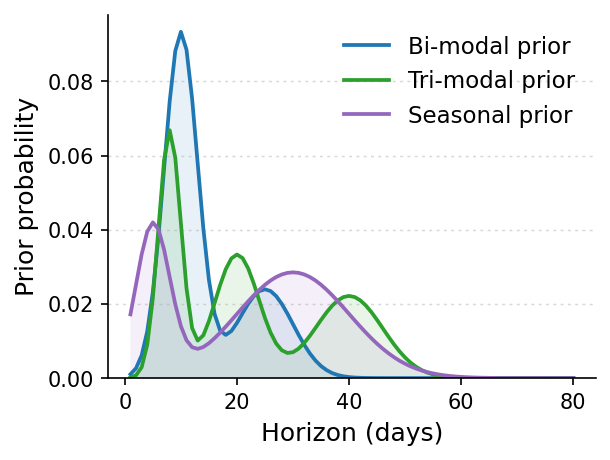

Saved: figs-bosun/experiment4.png

LaTeX rows:
Bi-modal typical & $0.7\,\mathcal{{N}}(10,3^2) + 0.3\,\mathcal{{N}}(25,5^2)$ & $\approx 10,25$ & 81 \\
Tri-modal balanced & $\tfrac{{1}}{{3}}\mathcal{{N}}(8,2^2) + \tfrac{{1}}{{3}}\mathcal{{N}}(20,4^2) + \tfrac{{1}}{{3}}\mathcal{{N}}(40,6^2)$ & $\approx 8,20,40$ & 81 \\
Seasonal peak & $0.3\,\mathcal{{N}}(5,3^2) + 0.7\,\mathcal{{N}}(30,10^2)$ & $\approx 5,30$ & 81 \\


In [6]:
# ---------------------------
# 그림: 단일 패널에서 세 prior + t* 비교
# ---------------------------

fig, ax = plt.subplots(figsize=(4.2, 3.2))  # 세로 조금 더 긴 비율

x = np.arange(1, M+1)
shadow = [pe.withStroke(linewidth=3, foreground="white", alpha=0.9)]

# y축 최대값(공통 스케일)
global_max = max(prior_bi.max(), prior_tri.max(), prior_season.max())

def plot_case(ax, prior, t_star, color, label):
    # prior 곡선 + 리본
    ax.plot(x, prior, color=color, linewidth=1.8, label=label)
    ax.fill_between(x, 0, prior, color=color, alpha=0.10, edgecolor="none")

    # t* 점선
    if t_star <= M:
        ax.axvline(t_star, color=color, linestyle="--", linewidth=1.6, alpha=0.9)
        # t* 라벨은 너무 복잡해지면 빼도 됨. 필요하면 아래 주석 해제
        # ax.text(
        #     t_star + 0.5,
        #     global_max * 0.9,
        #     r"$t^\*$",
        #     color=color,
        #     fontsize=10,
        #     va="top",
        #     ha="left",
        #     path_effects=shadow
        # )

# 세 prior를 서로 다른 색으로 한 축에 겹쳐서 그림
plot_case(ax, prior_bi,   t_bi,   "tab:blue",   "Bi-modal prior")
plot_case(ax, prior_tri,  t_tri,  "tab:green",  "Tri-modal prior")
plot_case(ax, prior_season, t_sea, "tab:purple", "Seasonal prior")

# 축/레이블/눈금
ax.set_xlabel("Horizon (days)")
ax.set_ylabel("Prior probability")
ax.set_ylim(0, global_max * 1.05)
ax.grid(True, axis="y", linestyle=(0, (2, 3)), linewidth=0.7, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# 세 prior 비교용 legend
ax.legend(frameon=False, loc="upper right")

fig.tight_layout()
out_png = "figs-bosun/experiment4.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved: {out_png}")

print()
print("LaTeX rows:")
print(f"Bi-modal typical & "
      r"$0.7\,\mathcal{{N}}(10,3^2) + 0.3\,\mathcal{{N}}(25,5^2)$ & "
      r"$\approx 10,25$ & "
      f"{t_bi} \\\\")

print(f"Tri-modal balanced & "
      r"$\tfrac{{1}}{{3}}\mathcal{{N}}(8,2^2) + "
      r"\tfrac{{1}}{{3}}\mathcal{{N}}(20,4^2) + "
      r"\tfrac{{1}}{{3}}\mathcal{{N}}(40,6^2)$ & "
      r"$\approx 8,20,40$ & "
      f"{t_tri} \\\\")

print(f"Seasonal peak & "
      r"$0.3\,\mathcal{{N}}(5,3^2) + 0.7\,\mathcal{{N}}(30,10^2)$ & "
      r"$\approx 5,30$ & "
      f"{t_sea} \\\\")



[t*] Bi-modal: 81, Tri-modal: 81, Seasonal: 81


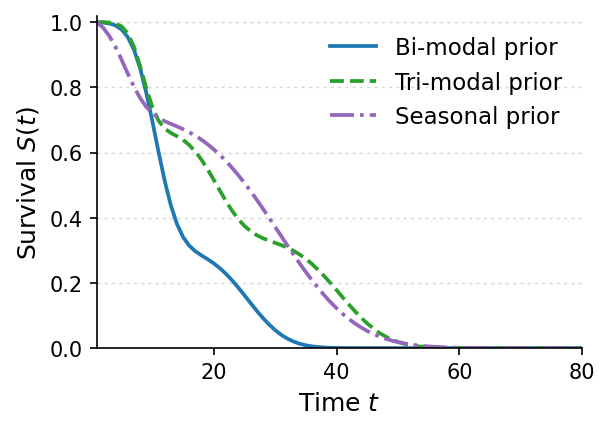

Saved survival figure to: figs-bosun/experiment4_survival.png


In [18]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------------------------
# 기본 스타일 (논문용)
# ---------------------------
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": [
        "DejaVu Sans",
        "Helvetica",
        "Arial",
    ],
    "font.weight": "regular",
    "font.size": 11,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.7,
    "savefig.dpi": 600,
    "figure.dpi": 150,
})

os.makedirs("figs-bosun", exist_ok=True)

# ---------------------------
# 유틸: prior 생성 & 정규화
# ---------------------------
def discretize_gaussian_mixture(M, components):
    """
    components: list of (weight, mu, sigma)
    returns prior over k=1..M (np.array length M)
    """
    x = np.arange(1, M+1)
    p = np.zeros_like(x, dtype=float)
    for w, mu, sigma in components:
        p += w * norm.pdf(x, loc=mu, scale=sigma)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

def discretize_trimodal(M, modes, stds, weights):
    x = np.arange(1, M+1)
    p = np.zeros(M, dtype=float)
    for w, m, s in zip(weights, modes, stds):
        p += w * norm.pdf(x, loc=m, scale=s)
    s = p.sum()
    return p / s if s > 0 else np.ones(M)/M

# ---------------------------
# t* 계산 (Bayesian 잔여렌탈 규칙)
# ---------------------------
def optimal_t_star(b, M, prior):
    """
    prior[k-1] = P(T = k)
    buy at first t with b <= E[min{T - t + 1, b} | T >= t].
    if never, return M+1 (never buy)
    """
    prior = np.asarray(prior, dtype=float)
    prior /= prior.sum()
    # 누적 생존확률 Z_t = P[T >= t]
    Z = np.flip(np.cumsum(np.flip(prior)))  # Z[t-1] = sum_{k=t..M} prior[k-1]
    for t in range(1, M+1):
        if Z[t-1] <= 0:
            continue
        ks = np.arange(t, M+1)
        post = prior[ks-1] / Z[t-1]
        rent_costs = np.minimum(ks - t + 1, b)
        E_rent = np.sum(post * rent_costs)
        if b <= E_rent:
            return t
    return M + 1

# ---------------------------
# 케이스 정의 (Experiment 4와 동일)
# ---------------------------
M = 80
b = 25

# (1) Bi-modal Typical: 0.7*N(10,3^2) + 0.3*N(25,5^2)
prior_bi = discretize_gaussian_mixture(
    M, components=[(0.7, 10, 3), (0.3, 25, 5)]
)

# (2) Tri-modal Balanced
prior_tri = discretize_trimodal(
    M, modes=[8, 20, 40], stds=[2, 4, 6], weights=[1/3, 1/3, 1/3]
)

# (3) Seasonal Peak
prior_season = discretize_gaussian_mixture(
    M, components=[(0.3, 5, 3), (0.7, 30, 10)]
)

# t* 계산
t_bi  = optimal_t_star(b, M, prior_bi)
t_tri = optimal_t_star(b, M, prior_tri)
t_sea = optimal_t_star(b, M, prior_season)

print(f"[t*] Bi-modal: {t_bi}, Tri-modal: {t_tri}, Seasonal: {t_sea}")

# ---------------------------
# Survival function S(t) = P[T >= t] 계산
# ---------------------------
x = np.arange(1, M+1)

def survival(prior):
    # S[t-1] = sum_{k=t..M} prior[k-1]
    return np.flip(np.cumsum(np.flip(prior)))

S_bi     = survival(prior_bi)
S_tri    = survival(prior_tri)
S_season = survival(prior_season)

# ---------------------------
# 그림: 세 prior의 S(t) 비교 + t* 표시
# ---------------------------
# ---------------------------
# Survival function figure (colors match prior-density figure)
# ---------------------------

fig, ax = plt.subplots(figsize=(4.2, 3.0))

# Survival curves
ax.plot(x, S_bi,     color="tab:blue",   linestyle="-",  linewidth=1.8, label="Bi-modal prior")
ax.plot(x, S_tri,    color="tab:green",  linestyle="--", linewidth=1.8, label="Tri-modal prior")
ax.plot(x, S_season, color="tab:purple", linestyle="-.", linewidth=1.8, label="Seasonal prior")

# t* vertical lines (same colors)
if t_bi <= M:
    ax.axvline(t_bi, color="tab:blue", linestyle="--", alpha=0.7, linewidth=1.4)
if t_tri <= M:
    ax.axvline(t_tri, color="tab:green", linestyle="--", alpha=0.7, linewidth=1.4)
if t_sea <= M:
    ax.axvline(t_sea, color="tab:purple", linestyle="--", alpha=0.7, linewidth=1.4)

# Labels
ax.set_xlabel("Time $t$")
ax.set_ylabel("Survival $S(t)$")  # safe mathtext
ax.set_xlim(1, M)
ax.set_ylim(0, 1.02)

# Styling
ax.grid(True, axis="y", linestyle=(0, (2, 3)), linewidth=0.7, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(frameon=False, loc="upper right")

fig.tight_layout()
out_png = "figs-bosun/experiment4_survival.png"
fig.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved survival figure to: {out_png}")

